In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from AAEstat import calcAAE, calcBrCAAE, calcAAE_CI, linReg95

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ACP_mpl_style.mplstyle')

In [13]:
from pathlib import Path
base_dir = Path('/Users/jdabutler/Documents/+github/rx burn') # your path here
plot_dir = base_dir / 'plots'

# Load and prepare AAE data

In [5]:
path = base_dir /'AAE datasets'
raw = pd.read_csv(path/'AAE_1Hz_2025-02-24.csv')
raw['datetime'] = pd.to_datetime(raw['datetime'])

# constants
wl = [370,470,520,590,660,880,950] #wavelengths of AE33
macs = [18.47,14.54,13.14,11.58,10.35,7.77,7.19] #mass absorption cross section

#minutely absorption dataframe
Abs1Hz = raw[['datetime','b_370','b_470','b_520','b_590','b_660','b_880','b_950']].set_index('datetime')
Abs = Abs1Hz.resample('1T').mean()
Abs['Count'] = Abs1Hz[['b_880']].resample('1T').count()

# 90% observations per minute threshold
threshold = 54 # 54/60 is 90%
Abs = Abs.loc[Abs['Count']>54]

# 7 pt AAE and R2
series = Abs.apply(calcAAE,axis=1,wl=wl,label='7pt')
Abs = pd.concat([Abs,series],axis=1)

# six point AAE (exclude 370 nm)
wl6 = [470,520,590,660,880,950] #wavelengths of AE33
series =  Abs.apply(calcAAE,axis=1,wl=wl6,label='6pt')
Abs = pd.concat([Abs,series],axis=1)

# calculate two point AAEs
Abs['AAE_470-880'] = - np.log(Abs['b_470']/Abs['b_880']) / np.log(wl[1]/wl[5])
Abs['C_470-880'] = np.exp(np.log(Abs['b_470']) + Abs['AAE_470-880']*np.log(wl[1]))

Abs['AAE_370-880'] = - np.log(Abs['b_370']/Abs['b_880']) / np.log(wl[0]/wl[5])
Abs['C_370-880'] = np.exp(np.log(Abs['b_370']) + Abs['AAE_370-880']*np.log(wl[0]))

Abs['AAE_880-950'] = - np.log(Abs['b_880']/Abs['b_950']) / np.log(wl[5]/wl[6]) # BC AAE
Abs['C_880-950'] = np.exp(np.log(Abs['b_880']) + Abs['AAE_880-950']*np.log(wl[5]))

Abs['AAE_470-660'] = - np.log(Abs['b_470']/Abs['b_660']) / np.log(wl[1]/wl[4])
Abs['C_470-660'] = np.exp(np.log(Abs['b_470'])+Abs['AAE_470-660']*np.log(wl[1]))



meanAbs = Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].mean()
meanC = Abs['C_7pt'].mean()

AAE7 = Abs['AAE_7pt'].mean()
AAE6 = Abs['AAE_6pt'].mean()

AAE48 = Abs['AAE_470-880'].mean()
AAE38 = Abs['AAE_370-880'].mean()

# Brown Carbon Absorption subtracted

In [6]:
wlBrC = wl[0:5]

for w in wlBrC:
    Abs['b_' + str(w) + '_BrC'] = Abs['b_'+str(w)] - Abs['C_880-950'] / (w**Abs['AAE_880-950'])

Abs['AAE_370-470'] = - np.log(Abs['b_370_BrC']/Abs['b_470_BrC']) / np.log(wl[0]/wl[1]) # BrC AAE - updated to be BC subtracted BrC specific absorption
Abs['C_370-470'] = np.exp(np.log(Abs['b_370_BrC']) + Abs['AAE_370-470']*np.log(wl[0]))

meanAbsBrC = Abs[['b_370_BrC', 'b_470_BrC', 'b_520_BrC', 'b_590_BrC', 'b_660_BrC']].mean()

# five point BrC AAE
wlBrC = [370,470,520,590,660]
series = Abs.apply(calcBrCAAE,axis=1,wl=wlBrC,label='BrC')
Abs = pd.concat([Abs,series],axis=1)

/Users/jdabutler/Documents/+github/rx burn/jupyter notebooks/AAEstat.py:63: RuntimeWarning: invalid value encountered in log
  log_b = np.log(b_abs)


# BC AAE Sensitivity Analysis

In [7]:
AbsSA = Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].copy()

meanAbsBrC = Abs[['b_370_BrC', 'b_470_BrC', 'b_520_BrC', 'b_590_BrC', 'b_660_BrC']].mean()

AAE1 = 1
AbsSA['C1'] = np.exp(np.log(AbsSA['b_880']) + AAE1*np.log(wl[5]))

for w in wlBrC:
    AbsSA['b_' + str(w) +'_BrC'] = AbsSA['b_'+str(w)] - AbsSA['C1'] / (w**AAE1)
    
meanSA = AbsSA[['b_370_BrC', 'b_470_BrC', 'b_520_BrC', 'b_590_BrC', 'b_660_BrC']].mean()

# average BrC AAE
BrC_avg,BrC_l,BrC_u,C_BrC,Cl,Cu,r2_BrC = calcAAE_CI(meanSA[0:5],wlBrC[0:5])
BrC_u


8.256655527571999

# AAE Sensitivity Analysis

(0.0, 4.0)

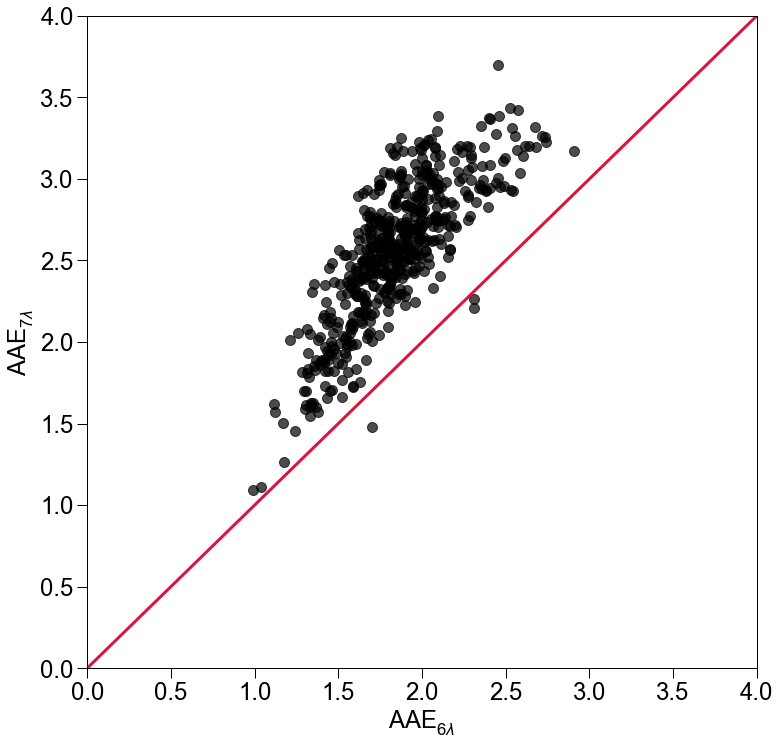

In [11]:
fig,ax = plt.subplots(figsize=(12,12))

ax.plot(Abs['AAE_6pt'],Abs['AAE_7pt'],'ok',alpha=0.7)
ax.plot([0,4],[0,4],color='#DC143C')

ax.set_ylabel('AAE$_{{7\lambda}}$')
ax.set_xlabel('AAE$_{{6\lambda}}$')

lims = [0,4]
ax.set_xlim(lims)
ax.set_ylim(lims)

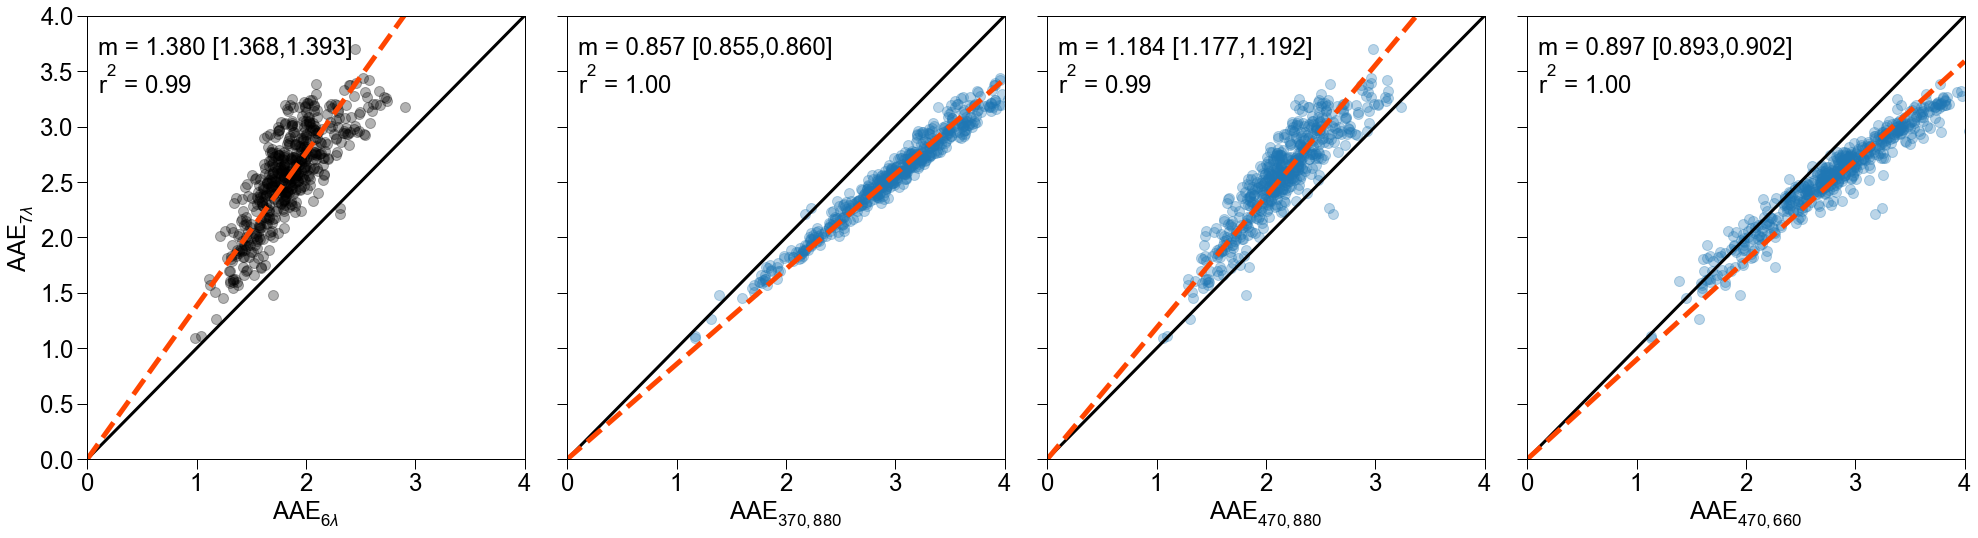

In [14]:
fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(28,8))

al = 0.3
ax[0].plot(Abs['AAE_6pt'],Abs['AAE_7pt'],'ok',alpha=al)
ax[1].plot(Abs['AAE_370-880'],Abs['AAE_7pt'],'o',alpha = al)
ax[2].plot(Abs['AAE_470-880'],Abs['AAE_7pt'],'o',alpha = al)
ax[3].plot(Abs['AAE_470-660'],Abs['AAE_7pt'],'o',alpha = al)

ax[0].set_xlim([0,4])
ax[0].set_ylim([0,4])

xlabels = ['AAE$_{{6\lambda}}$','AAE$_{370,880}$','AAE$_{470,880}$','AAE$_{470,660}$']
cols = ['AAE_6pt','AAE_370-880','AAE_470-880','AAE_470-660']
x = np.arange(0,4.5,0.5)

for i in np.arange(4):
    ax[i].plot([0,4],[0,4],'-k')
    ax[i].set_xlabel(xlabels[i])
    m,m_l,m_u,r2,r = linReg95(Abs[cols[i]],Abs['AAE_7pt'])
    
    ax[i].plot(x,x*m,'--',color = '#FF4500',lw=5)
    #ax[i].plot(x,x*m_l,':',color = '#FF4500',lw=5)
    #ax[i].plot(x,x*m_u,':',color = '#FF4500',lw=5)
    
    ax[i].annotate('m = {:.3f} [{:.3f},{:.3f}]\nr$^2$ = {:.2f}'.format(m,m_u,m_l,r2),xy=(0.1,3.3))

ax[0].set_ylabel('AAE$_{{7\lambda}}$')
fig.tight_layout()

fig.savefig(plot_dir/'AAE_SenAnalysis.png')

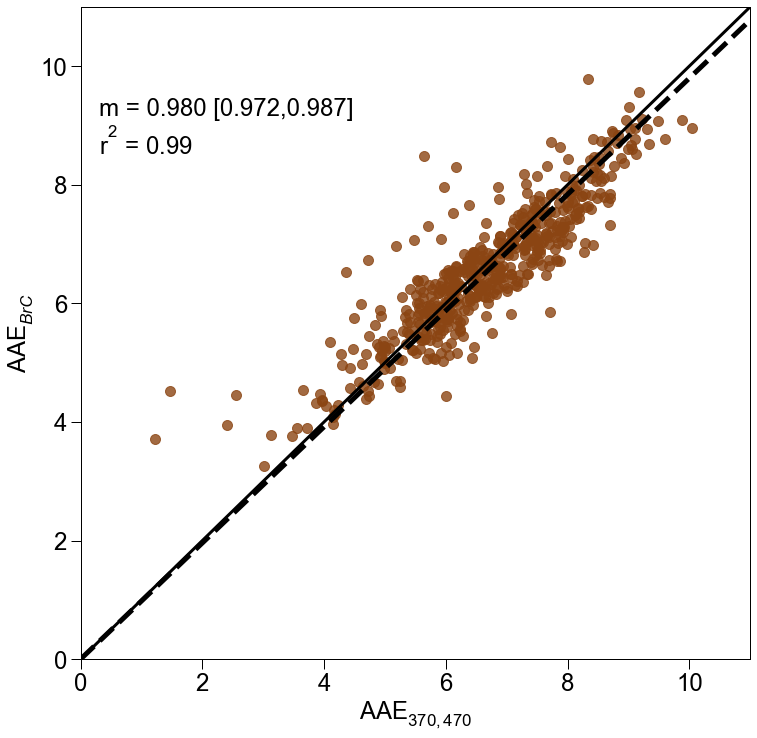

In [15]:
fig,ax = plt.subplots(figsize=(12,12))

ax.plot(Abs['AAE_370-470'],Abs.AAE_BrC,'o',color='#8B4513',alpha=0.8)

ax.set_ylabel('AAE$_{BrC}$')
ax.set_xlabel('AAE$_{370,470}$')

lims = [0,11]
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims,lims,'-k')

x = np.arange(12)
m,m_l,m_u,r2,r = linReg95(Abs['AAE_370-470'],Abs['AAE_BrC'])

ax.plot(x,x*m,'--k',lw=5)
ax.annotate('m = {:.3f} [{:.3f},{:.3f}]\nr$^2$ = {:.2f}'.format(m,m_u,m_l,r2),xy=(0.3,8.5))

fig.savefig(plot_dir/'AAE_BrC_SenAnalysis.png')

# AAE vs MCE

In [16]:
# minutely MCE
# Full aethalometer data
fname = base_dir /'aligned CSV'
MCE_T = pd.read_csv(fname/'MCE_integrated_minutely.csv')
MCE_T['datetime'] = pd.to_datetime(MCE_T['datetime'])
MCE_T.set_index('datetime',inplace=True)

In [17]:
def OLSconstCI(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y) #& (X < 5) & (X > 0) & (Y < 5) & (Y > 0)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    #s_u = r.conf_int().values[1,0]
    #s_l = r.conf_int().values[1,1]
    #b_u = r.conf_int().values[0,0]
    #b_l = r.conf_int().values[0,1]
    
    return s,b,r2,r

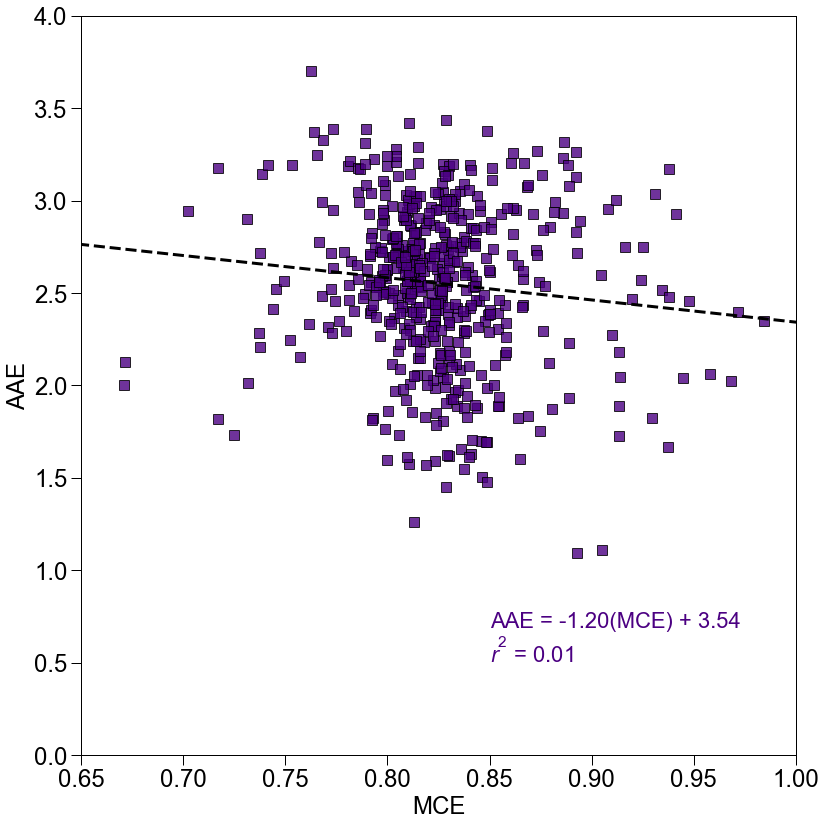

In [18]:
compare = pd.merge(MCE_T,Abs[['AAE_370-470','AAE_880-950','AAE_BrC','AAE_6pt','AAE_7pt']].reset_index(),on='datetime')

fig,ax=plt.subplots(figsize=(12,12))
ax.plot(compare.MCE,compare.AAE_7pt,'s',color='#4B0082',markeredgecolor='k',alpha=0.8)

s,b,r2,r = OLSconstCI(compare.MCE,compare['AAE_7pt'])
x = np.linspace(0.6,1.1)
y = x*s+b
ax.plot(x,y,'--k')
ax.annotate(rf'AAE = {s:.2f}(MCE) + {b:.2f}' '\n' r'$r^2$ = ' f'{r2:.2f}', xy=(0.85, 0.5),fontsize=22,color='#4B0082')

ax.set_ylabel('AAE')
ax.set_xlabel('MCE')
ax.set_xlim([0.65,1])
ax.set_ylim([0,4])

fig.tight_layout()

0.0006063457054296117


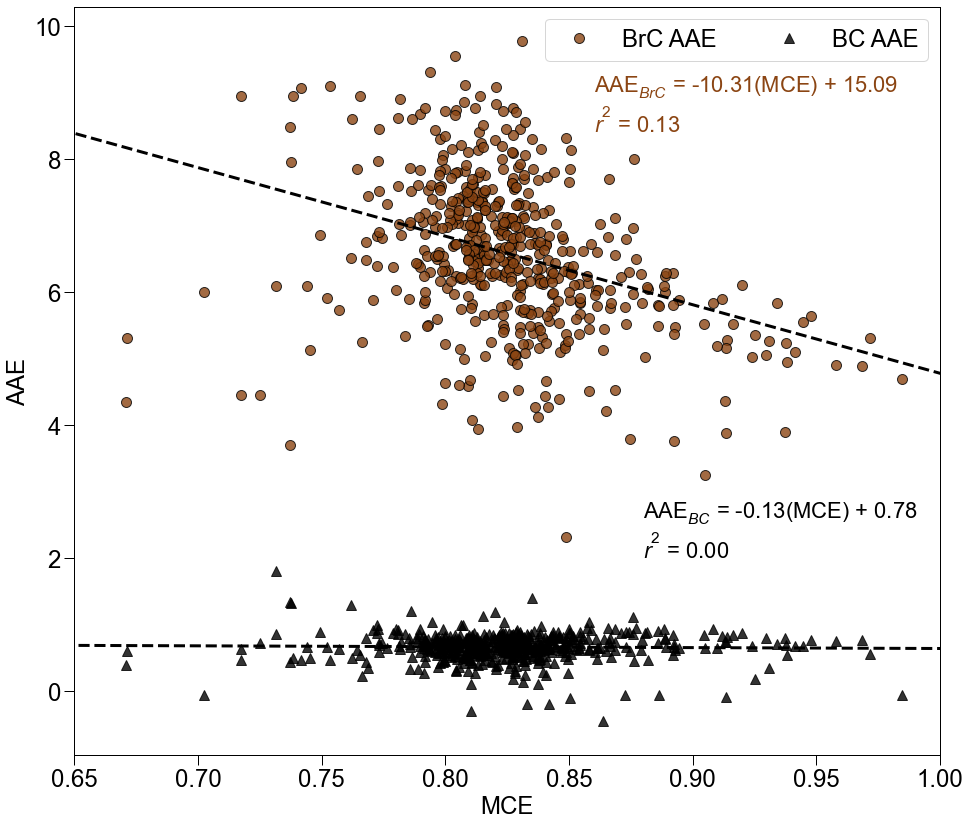

In [19]:
fig,ax=plt.subplots(figsize=(14,12))

ax.plot(compare.MCE,compare['AAE_BrC'],'o',color='#8B4513',markeredgecolor='k',alpha=0.8,label='BrC AAE')
ax.plot(compare.MCE,compare['AAE_880-950'],'^',color='k',alpha=0.8,label='BC AAE')

s,b,r2,r = OLSconstCI(compare.MCE,compare['AAE_BrC'])
x = np.linspace(0.6,1.1)
y = x*s+b
ax.plot(x,y,'--k')
ax.annotate(rf'AAE$_{{BrC}}$ = {s:.2f}(MCE) + {b:.2f}' '\n' r'$r^2$ = ' f'{r2:.2f}', xy=(0.86, 8.4),fontsize=22,color='#8B4513')

s,b,r2,r = OLSconstCI(compare.MCE,compare['AAE_880-950'])
x = np.linspace(0.6,1.1)
y = x*s+b
ax.plot(x,y,'--k')
ax.annotate(rf'AAE$_{{BC}}$ = {s:.2f}(MCE) + {b:.2f}' '\n' r'$r^2$ = ' f'{r2:.2f}', xy=(0.88, 2),fontsize=22)


ax.legend(ncol=2)
ax.set_ylabel('AAE')
ax.set_xlabel('MCE')
ax.set_xlim([0.65,1])
#ax.set_ylim([0,4])
print(r2)
fig.tight_layout()

# R2 for AAEs against entire curve

In [20]:
from sklearn.metrics import r2_score
from scipy.optimize import minimize

In [21]:
def calcR2(row,wl,AAE_suffix):
    
    wl = np.array(wl)
    
    # AAE from row
    AAE = row['AAE_'+AAE_suffix]
    
    b_abs = row[['b_' + str(wl[i]) for i in range(len(wl))]].to_list()
    meanAbs = np.mean(np.array(b_abs))
    C = row['C_'+AAE_suffix]
    
    # calculated predicted absorption from power-law fit and 
    b_pre = C*(wl)**(-AAE)

    # calculate R2
    r2 = r2_score(b_abs,b_pre)
    
    return pd.Series(r2,index=['r2_'+AAE_suffix])

In [23]:
R2 = Abs[['r2_7pt','r2_BrC']]
suffixes = ['6pt','370-880','470-880','470-660']

# Total absorption curve
for s in suffixes:
    series = Abs.apply(calcR2,axis=1,wl=wl,AAE_suffix=s)
    R2 = pd.concat([R2,series],axis=1)
    
# BrC 
series = Abs.apply(calcR2,axis=1,wl=wl[0:5],AAE_suffix='370-470')
R2 = pd.concat([R2,series],axis=1)
R2

,r2_7pt,r2_BrC,r2_6pt,r2_370-880,r2_470-880,r2_470-660,r2_370-470
datetime,,,,,,,
2021-04-20 12:03:00,0.967337,0.996948,0.795923,0.946469,0.890417,0.931493,0.462044
2021-04-20 12:44:00,0.866788,0.989575,0.348911,0.834956,0.512837,0.608428,0.851807
2021-04-20 12:51:00,0.893057,0.990343,0.507474,0.830735,0.651607,0.726441,0.459183
2021-04-20 12:52:00,0.923063,0.987353,0.677587,0.861495,0.807601,0.863455,-0.557362
2021-04-20 12:56:00,0.907567,0.996278,0.561224,0.850683,0.701439,0.784330,0.391280
...,...,...,...,...,...,...,...
2021-04-23 14:51:00,0.832738,0.996125,0.208218,0.870465,0.470791,0.679648,0.973031
2021-04-23 15:04:00,0.773069,0.995221,0.084086,0.841439,0.306583,0.477691,0.982662
2021-04-23 15:05:00,0.764796,0.996079,0.077842,0.833382,0.297403,0.471059,0.981335


# Manuscript Plots

## AAE Distributions

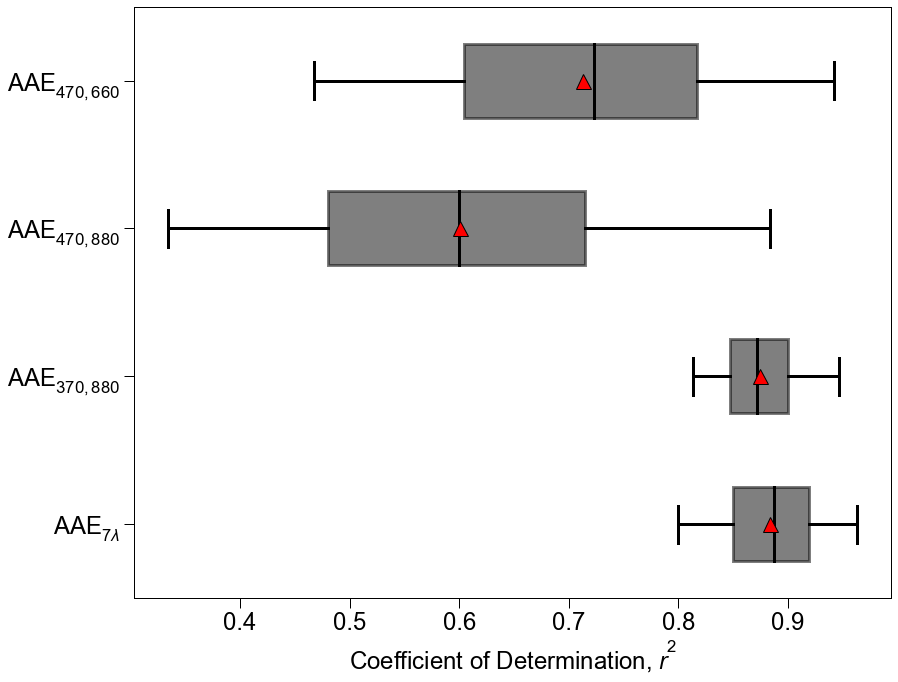

In [24]:
# box and whisker
lw = 3
boxprops=dict(linewidth=lw,color='k')
medianprops=dict(linewidth=lw,linestyle='-',color='k')
whiskerprops = dict(linewidth=lw)
capprops = dict(linewidth=lw)
meanprops = dict(markersize=15,markerfacecolor='r',markeredgecolor='k')
flierprops = dict(markersize=10)

fig,ax = plt.subplots(figsize=(13,10))

# converstion factor of ug to g
CF = 1e6

pos = np.arange(4)
box = ax.boxplot(R2[['r2_7pt','r2_370-880','r2_470-880','r2_470-660']],
                  positions=pos,whis=[5,95],showfliers=False,showmeans=True,
                  boxprops=boxprops,flierprops=flierprops,
                  medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,meanprops=meanprops,patch_artist=True,widths=0.5,zorder=0,vert=False)
#ax.axhline(y=1.5,ls='-',color='k')

ylabels = ['AAE$_{{7\lambda}}$','AAE$_{370,880}$','AAE$_{470,880}$','AAE$_{470,660}$']
ax.set_yticklabels(ylabels)

for i,_ in enumerate(pos):
    box['boxes'][i].set(facecolor='k',alpha=0.5)  

ax.set_xlabel('Coefficient of Determination, $r^2$',fontweight=None)

# Add supplementary y-axis labels above and below axhline
#ax.text(-0.1, .5, 'Total Absorption', fontsize=24, rotation=90, va='center',fontweight='bold')
#ax.text(-0.1, 0.5, 'Brown Carbon', fontsize=24, rotation=90, va='center',fontweight='bold',color='#8B4513')

fig.tight_layout()
fig.savefig(plot_dir/'R2_boxplots_totalOnly.png')

## Absorption Curves

6.255210053230757 5.37223083789687 7.138189268564643
2.315973935095983 1.3459357777657797 3.286012092426186


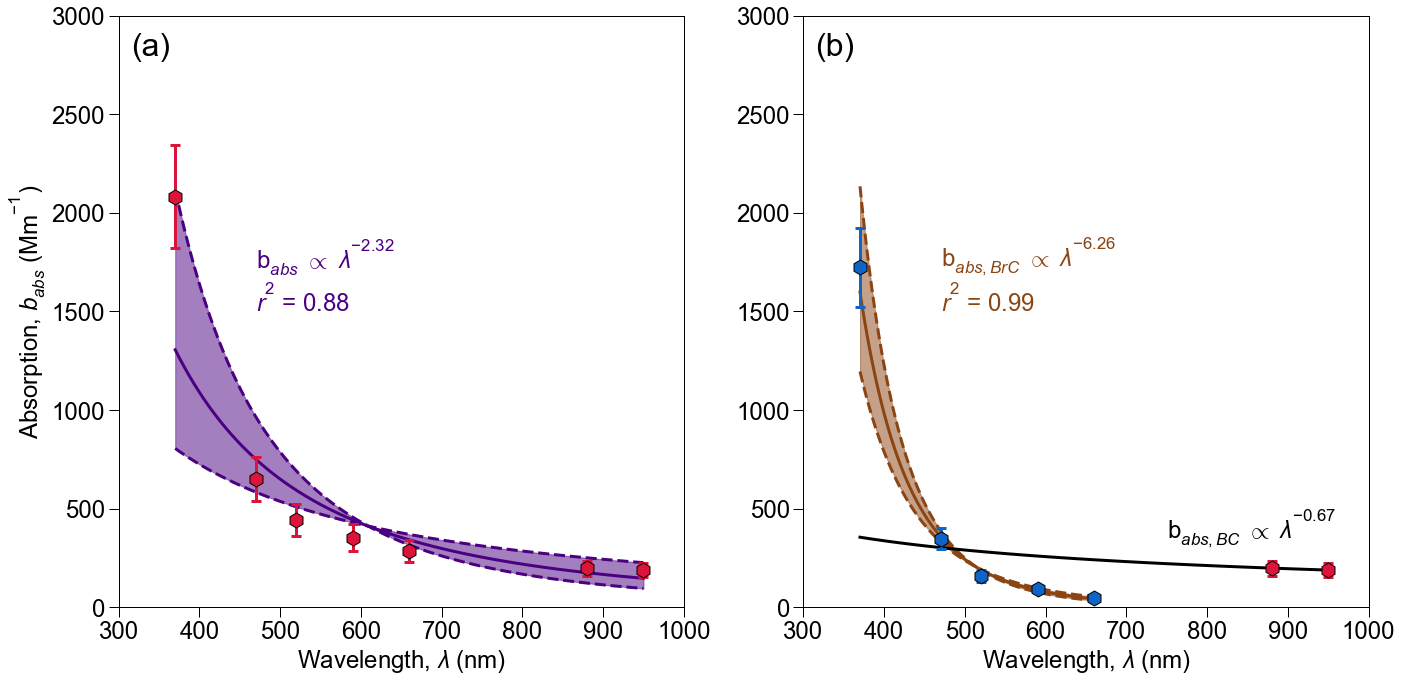

In [25]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

# converstion factor 
CF = 1e3 # convert from per 10**9 meters to per Mm

# left panel
ax[0].errorbar(x=wl,y=meanAbs/CF,
               yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#DC143C',ms=15,markeredgecolor='k',linestyle='',zorder=10)

# right panel
# BC
ax[1].errorbar(x=wl[-2:],y=meanAbs[-2:]/CF,
               yerr=Abs[['b_880', 'b_950']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#DC143C',ms=15,markeredgecolor='k',linestyle='',zorder=10)
# BrC
ax[1].errorbar(x=wlBrC,y=meanAbsBrC/CF,
               yerr=Abs[['b_370_BrC', 'b_470_BrC', 'b_520_BrC', 'b_590_BrC', 'b_660_BrC']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#0F64C7',ms=15,markeredgecolor='k',linestyle='',zorder=10)


for i in range(2):
    ax[i].set_xlim([300,1000])
    ax[i].set_ylim([0,3*CF])
    ax[i].set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax[0].set_ylabel('Absorption, $b_{abs}$ (Mm$^{-1}$)',fontweight=None)

# ------------------------------------------------------------------------------------------------------------------------------------------------ #

# average BrC AAE
BrC_avg,BrC_l,BrC_u,C_BrC,Cl,Cu,r2_BrC = calcAAE_CI(meanAbsBrC[0:5],wlBrC[0:5])

print(BrC_avg,BrC_l,BrC_u)
x = np.linspace(wl[0],wl[4],100)
y = C_BrC/CF*(x)**(-BrC_avg)
ax[1].plot(x,y,'-',color='#8B4513')

yl = Cl/CF*(x)**(-BrC_l)
ax[1].plot(x,yl,'--',color='#8B4513')

yu = Cu/CF*(x)**(-BrC_u)
ax[1].plot(x,yu,'--',color='#8B4513')
ax[1].fill_between(x,yl,yu,alpha=0.5,color='#8B4513')

ax[1].annotate(f"b$_{{abs,BrC}}$ $\\propto$ $\\lambda^{{-{BrC_avg:.2f}}}$\n$r^2$ = ${{{r2_BrC:.2f}}}$", xy=(470, 1.5*CF),color = '#8B4513' )

# ------------------------------------------------------------------------------------------------------------------------------------------------ #
# average total AAE
AAE_avg,AAE_l,AAE_u,C,Cl,Cu,r2 = calcAAE_CI(meanAbs,wl)

x = np.linspace(wl[0],wl[6],100)
y = C/CF*(x)**(-AAE_avg)
ax[0].plot(x,y,'-',color='#4B0082')

yl = Cl/CF*(x)**(-AAE_l)
ax[0].plot(x,yl,'--',color='#4B0082')

yu = Cu/CF*(x)**(-AAE_u)
ax[0].plot(x,yu,'--',color='#4B0082')

ax[0].fill_between(x,yl,yu,alpha=0.5,color='#4B0082')

ax[0].annotate(f"b$_{{abs}}$ $\\propto$ $\\lambda^{{-{AAE_avg:.2f}}}$\n$r^2$ = ${{{r2:.2f}}}$", xy=(470, 1.5*CF),color = '#4B0082' )

print(AAE_avg,AAE_l,AAE_u)
# ------------------------------------------------------------------------------------------------------------------------------------------------ #
BC_AAE = - np.log(meanAbs['b_880']/meanAbs['b_950']) / np.log(wl[5]/wl[6]) # BC AAE
C_BC = np.exp(np.log(meanAbs['b_880']) + BC_AAE*np.log(wl[5])) 

x = np.linspace(wl[0],wl[6],100)
y = C_BC/CF*(x)**(-BC_AAE)
ax[1].plot(x,y,'-k')
#ax[0].plot(x,y,'-k')

delta = Abs['AAE_880-950'].sem()*1.96
yl = C_BC/CF*(x)**(-(BC_AAE-delta))
yu = C_BC/CF*(x)**(-(BC_AAE+delta))
#ax[1].plot(x,yl,'--k')
#ax[1].plot(x,yu,'--k')


ax[1].annotate(f"b$_{{abs,BC}}$ $\\propto$ $\\lambda^{{-{BC_AAE:.2f}}}$", xy=(750, 0.35*CF),color = 'k' )

# ------------------------------------------------------------------------------------------------------------------------------------------------ #
letters = ['(a)','(b)']
for i in range(2):
    ax[i].annotate(letters[i],xy=(315,2.8*CF),fontsize=32)

fig.tight_layout()
fig.savefig(plot_dir/'Abs_vs_WL_Study_BrCsub.png')

## Exit Talk Plot

6.255210053230757 5.37223083789687 7.138189268564643
2.315973935095983 1.3459357777657797 3.286012092426186


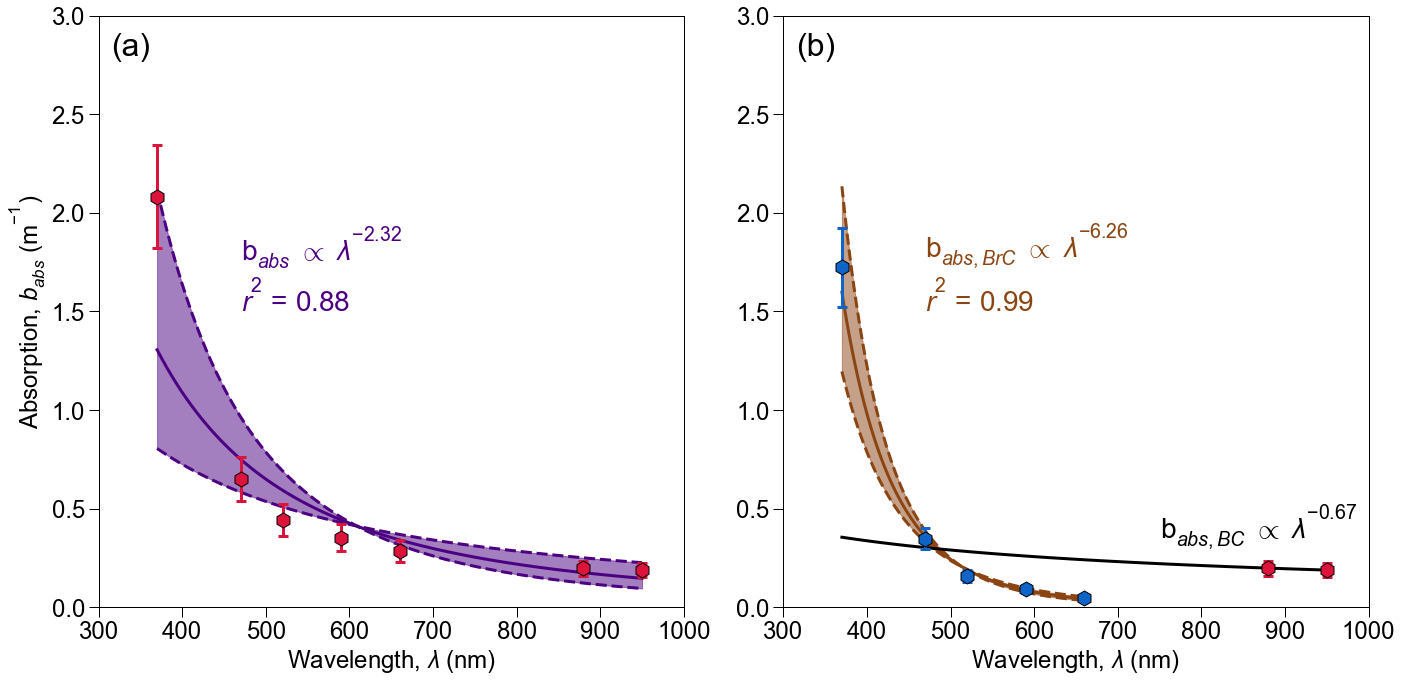

In [26]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

# converstion factor of ug to g
CF = 1e6

# left panel
ax[0].errorbar(x=wl,y=meanAbs/CF,yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#DC143C',ms=15,markeredgecolor='k',linestyle='',zorder=10)

# right panel
# BC
ax[1].errorbar(x=wl[-2:],y=meanAbs[-2:]/CF,yerr=Abs[['b_880', 'b_950']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#DC143C',ms=15,markeredgecolor='k',linestyle='',zorder=10)
# BrC
ax[1].errorbar(x=wlBrC,y=meanAbsBrC/CF,yerr=Abs[['b_370_BrC', 'b_470_BrC', 'b_520_BrC', 'b_590_BrC', 'b_660_BrC']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#0F64C7',ms=15,markeredgecolor='k',linestyle='',zorder=10)


for i in range(2):
    ax[i].set_xlim([300,1000])
    ax[i].set_ylim([0,3])
    ax[i].set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax[0].set_ylabel('Absorption, $b_{abs}$ (m$^{-1}$)',fontweight=None)

# ------------------------------------------------------------------------------------------------------------------------------------------------ #

# average BrC AAE
BrC_avg,BrC_l,BrC_u,C_BrC,Cl,Cu,r2_BrC = calcAAE_CI(meanAbsBrC[0:5],wlBrC[0:5])

print(BrC_avg,BrC_l,BrC_u)
x = np.linspace(wl[0],wl[4],100)
y = C_BrC/CF*(x)**(-BrC_avg)
ax[1].plot(x,y,'-',color='#8B4513')

yl = Cl/CF*(x)**(-BrC_l)
ax[1].plot(x,yl,'--',color='#8B4513')

yu = Cu/CF*(x)**(-BrC_u)
ax[1].plot(x,yu,'--',color='#8B4513')
ax[1].fill_between(x,yl,yu,alpha=0.5,color='#8B4513')

ax[1].annotate(f"b$_{{abs,BrC}}$ $\\propto$ $\\lambda^{{-{BrC_avg:.2f}}}$\n$r^2$ = ${{{r2_BrC:.2f}}}$", xy=(470, 1.5),color = '#8B4513',fontsize=28)

# ------------------------------------------------------------------------------------------------------------------------------------------------ #
# average total AAE
AAE_avg,AAE_l,AAE_u,C,Cl,Cu,r2 = calcAAE_CI(meanAbs,wl)

x = np.linspace(wl[0],wl[6],100)
y = C/CF*(x)**(-AAE_avg)
ax[0].plot(x,y,'-',color='#4B0082')

yl = Cl/CF*(x)**(-AAE_l)
ax[0].plot(x,yl,'--',color='#4B0082')

yu = Cu/CF*(x)**(-AAE_u)
ax[0].plot(x,yu,'--',color='#4B0082')

ax[0].fill_between(x,yl,yu,alpha=0.5,color='#4B0082')

ax[0].annotate(f"b$_{{abs}}$ $\\propto$ $\\lambda^{{-{AAE_avg:.2f}}}$\n$r^2$ = ${{{r2:.2f}}}$", xy=(470, 1.5),color = '#4B0082',fontsize=28)

print(AAE_avg,AAE_l,AAE_u)
# ------------------------------------------------------------------------------------------------------------------------------------------------ #
BC_AAE = - np.log(meanAbs['b_880']/meanAbs['b_950']) / np.log(wl[5]/wl[6]) # BC AAE
C_BC = np.exp(np.log(meanAbs['b_880']) + BC_AAE*np.log(wl[5])) 

x = np.linspace(wl[0],wl[6],100)
y = C_BC/CF*(x)**(-BC_AAE)
ax[1].plot(x,y,'-k')
#ax[0].plot(x,y,'-k')

delta = Abs['AAE_880-950'].sem()*1.96
yl = C_BC/CF*(x)**(-(BC_AAE-delta))
yu = C_BC/CF*(x)**(-(BC_AAE+delta))
#ax[1].plot(x,yl,'--k')
#ax[1].plot(x,yu,'--k')


ax[1].annotate(f"b$_{{abs,BC}}$ $\\propto$ $\\lambda^{{-{BC_AAE:.2f}}}$", xy=(750, 0.35),color = 'k',fontsize=28)

# ------------------------------------------------------------------------------------------------------------------------------------------------ #
letters = ['(a)','(b)']
for i in range(2):
    ax[i].annotate(letters[i],xy=(315,2.8),fontsize=32)

fig.tight_layout()

3.4346464877362424 1.9335679889378408 4.935724986534644
2.315973935095983 1.3459357777657797 3.286012092426186


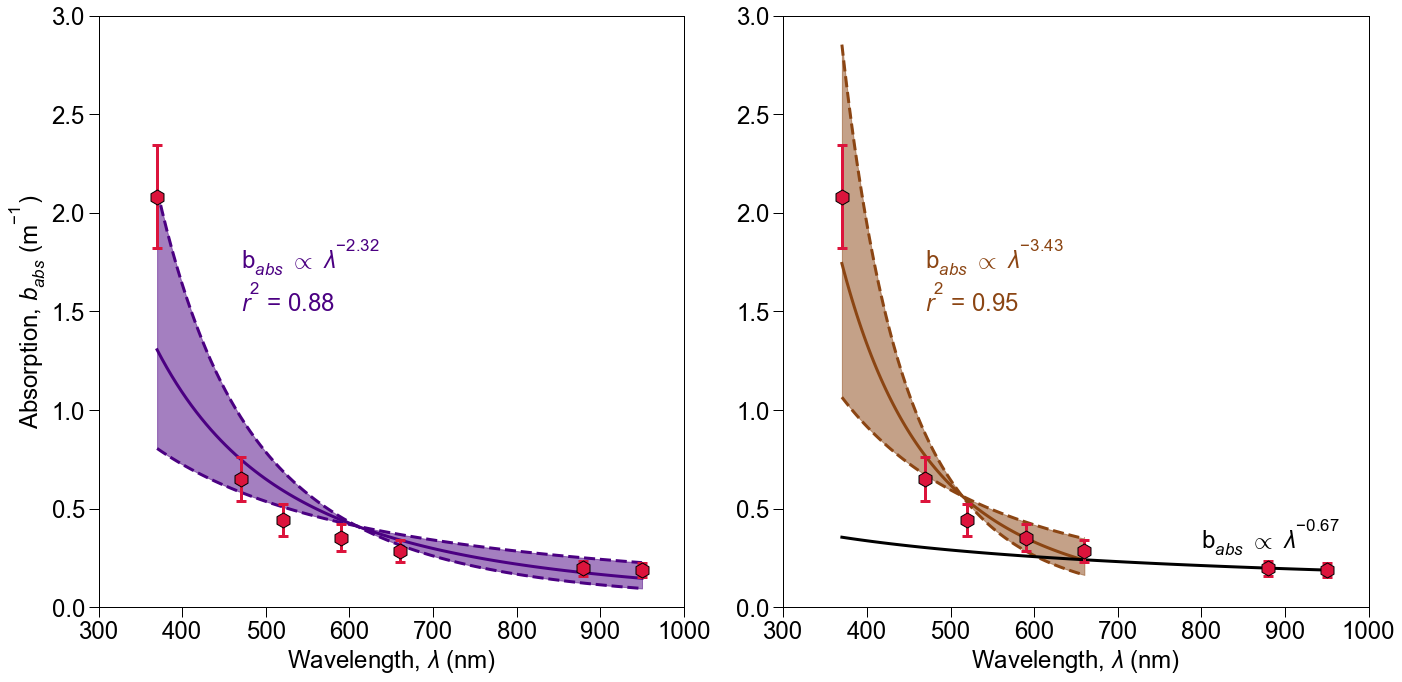

In [57]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

# converstion factor of ug to g
CF = 1e6

for i in range(2):
    ax[i].errorbar(x=wl,y=meanAbs/CF,yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()*1.96/CF,capsize=5,capthick=3,
                marker='h',color='#DC143C',ms=15,markeredgecolor='k',linestyle='',zorder=10)
    ax[i].set_xlim([300,1000])
    ax[i].set_ylim([0,3])
    ax[i].set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax[0].set_ylabel('Absorption, $b_{abs}$ (m$^{-1}$)',fontweight=None)

# ------------------------------------------------------------------------------------------------------------------------------------------------ #

# average BrC AAE
BrC_avg,BrC_l,BrC_u,C,Cl,Cu,r2_BrC = calcAAE_CI(meanAbs[0:5],wl[0:5])

print(BrC_avg,BrC_l,BrC_u)
x = np.linspace(wl[0],wl[4],100)
y = C/CF*(x)**(-BrC_avg)
ax[1].plot(x,y,'-',color='#8B4513')

yl = Cl/CF*(x)**(-BrC_l)
ax[1].plot(x,yl,'--',color='#8B4513')

yu = Cu/CF*(x)**(-BrC_u)
ax[1].plot(x,yu,'--',color='#8B4513')
ax[1].fill_between(x,yl,yu,alpha=0.5,color='#8B4513')

ax[1].annotate(f"b$_{{abs}}$ $\\propto$ $\\lambda^{{-{BrC_avg:.2f}}}$\n$r^2$ = ${{{r2_BrC:.2f}}}$", xy=(470, 1.5),color = '#8B4513' )

# ------------------------------------------------------------------------------------------------------------------------------------------------ #
# average total AAE
AAE_avg,AAE_l,AAE_u,C,Cl,Cu,r2 = calcAAE_CI(meanAbs,wl)

x = np.linspace(wl[0],wl[6],100)
y = C/CF*(x)**(-AAE_avg)
ax[0].plot(x,y,'-',color='#4B0082')

yl = Cl/CF*(x)**(-AAE_l)
ax[0].plot(x,yl,'--',color='#4B0082')

yu = Cu/CF*(x)**(-AAE_u)
ax[0].plot(x,yu,'--',color='#4B0082')

ax[0].fill_between(x,yl,yu,alpha=0.5,color='#4B0082')

ax[0].annotate(f"b$_{{abs}}$ $\\propto$ $\\lambda^{{-{AAE_avg:.2f}}}$\n$r^2$ = ${{{r2:.2f}}}$", xy=(470, 1.5),color = '#4B0082' )

print(AAE_avg,AAE_l,AAE_u)
# ------------------------------------------------------------------------------------------------------------------------------------------------ #
BC_AAE = - np.log(meanAbs['b_880']/meanAbs['b_950']) / np.log(wl[5]/wl[6]) # BC AAE
C_BC = np.exp(np.log(meanAbs['b_880']) + BC_AAE*np.log(wl[5])) 

x = np.linspace(wl[0],wl[6],100)
y = C_BC/CF*(x)**(-BC_AAE)
ax[1].plot(x,y,'-k')
#ax[0].plot(x,y,'-k')

delta = Abs['AAE_880-950'].sem()*1.96
yl = C_BC/CF*(x)**(-(BC_AAE-delta))
yu = C_BC/CF*(x)**(-(BC_AAE+delta))
#ax[1].plot(x,yl,'--k')
#ax[1].plot(x,yu,'--k')


ax[1].annotate(f"b$_{{abs}}$ $\\propto$ $\\lambda^{{-{BC_AAE:.2f}}}$", xy=(800, 0.3),color = 'k' )

# ------------------------------------------------------------------------------------------------------------------------------------------------ #

#ax.legend()
fig.tight_layout()
manuPath = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/_manuscript/plots/'
#fig.savefig(manuPath + 'Abs_vs_WL_Study_old.png')

In [27]:
BC_AAE = - np.log(meanAbs['b_880']/meanAbs['b_950']) / np.log(wl[5]/wl[6]) # BC AAE
BC_AAE

0.6713324253751607

In [30]:
delta = Abs['AAE_880-950'].sem()*1.96
delta

0.01799973119953444

In [31]:
Abs['AAE_880-950'] = - np.log(Abs['b_880']/Abs['b_950']) / np.log(wl[5]/wl[6]) # BC AAE
C_BC = np.exp(np.log(meanAbs['b_880']) + BC_AAE*np.log(wl[5])) 

# Modified Delta C method

In [32]:
def OLSconstCI(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y) #& (X < 5) & (X > 0) & (Y < 5) & (Y > 0)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    #s_u = r.conf_int().values[1,0]
    #s_l = r.conf_int().values[1,1]
    #b_u = r.conf_int().values[0,0]
    #b_l = r.conf_int().values[0,1]
    
    return s,b,r2,r

In [33]:
BrClit = pd.read_csv(base_dir/'literature emission factors'/'BrC_Literature.csv')
BrClit.drop('Unnamed: 0',axis=1,inplace=True)

## Load EF data
EF = pd.read_csv('/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/_manuscript/Blodgett_BC-BrC_EFs_2025-04-14.csv')
EF.rename({'Unnamed: 0':'datetime'},inplace=True,axis=1)

brc = EF[['datetime','MCE','BC_EF','BrC_EF']]
brc

,datetime,MCE,BC_EF,BrC_EF
0,2021-04-20 12:50:51,0.842696,0.897452,1.503807
1,2021-04-20 12:55:51,0.848970,0.916573,2.064026
2,2021-04-20 13:09:51,0.851037,1.552972,3.733560
3,2021-04-20 13:28:51,0.831161,1.236514,1.797067
4,2021-04-20 13:37:51,0.837687,1.697946,2.518545
...,...,...,...,...
61,2021-04-23 13:23:51,0.820123,0.344431,2.084089
62,2021-04-23 13:30:51,0.806031,0.190854,1.385638
63,2021-04-23 13:54:51,0.819450,0.145589,1.231054
64,2021-04-23 14:44:51,0.829990,0.122939,1.064904


In [35]:
brc['UVPM_EF'] = brc['BC_EF']+brc['BrC_EF']

MACS_370 = 18.47
MACS_880 = 7.77
AAE_BC = 0.67
MACS_BrC = 4.5

brc['mBrC_EF'] = (1/MACS_BrC)*(brc['UVPM_EF']*MACS_370 - brc['BC_EF']*MACS_880*(370/880)**(-AAE_BC))
brc.describe()

/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_67885/2697986811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brc['UVPM_EF'] = brc['BC_EF']+brc['BrC_EF']
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_67885/2697986811.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brc['mBrC_EF'] = (1/MACS_BrC)*(brc['UVPM_EF']*MACS_370 - brc['BC_EF']*MACS_880*(370/880)**(-AAE_BC))


,MCE,BC_EF,BrC_EF,UVPM_EF,mBrC_EF
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.828059,0.470263,1.586575,2.056839,6.991211
std,0.030247,0.400664,0.598516,0.894894,2.716845
min,0.768816,0.113852,0.807312,1.022634,3.532981
25%,0.807319,0.190909,1.222603,1.470705,5.408860
50%,0.824536,0.289665,1.403286,1.753484,6.053721
75%,0.840307,0.640924,1.744423,2.376068,7.887980
max,0.923523,1.697946,4.080322,5.286532,17.500667


Butler BrC r2 = 0.07350530690428647


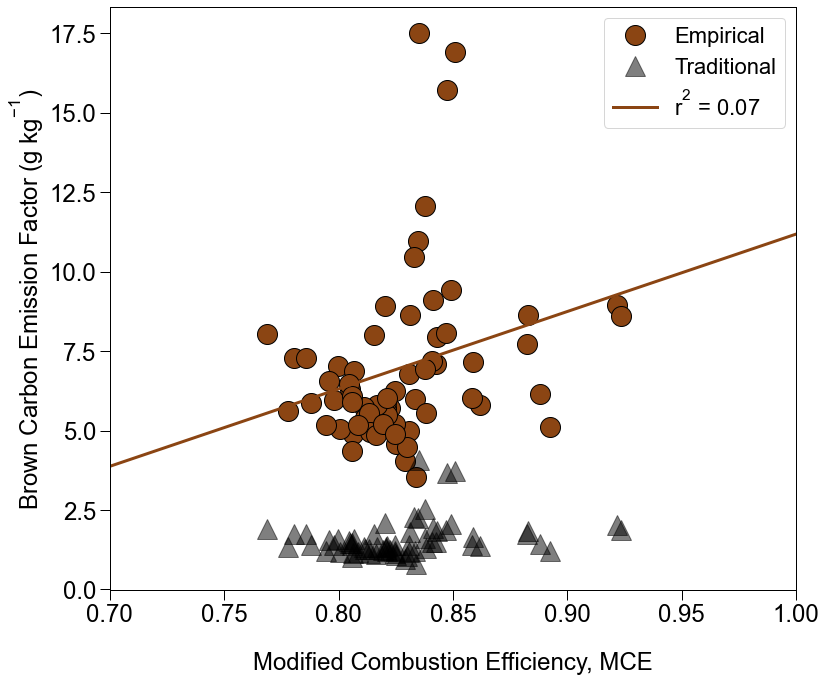

In [37]:
fig,ax = plt.subplots(figsize=(12,10))

# Brown Carbon ----------------------------------------------------------------------------- #
ax.plot(brc.MCE,brc.mBrC_EF,'o',ms=20,color='#8B4513',markeredgecolor='k',label='Empirical')

#ax2 = ax.twinx()
ax.plot(brc.MCE,brc.BrC_EF,'^',ms=20,color='k',alpha=0.5,label='Traditional')

x = np.arange(0.7,1.1,0.1)
s,b,r2,r = OLSconstCI(brc.MCE,brc.mBrC_EF)
But = s*x + b
line_but = ax.plot(x,But,'-',color='#8B4513',label='r$^2$ = {:.2f}'.format(r2))
print('Butler BrC r2 = ' + str(r2))

#sa,ba,r2a,ra = OLSconstCI(BrClit.MCE,BrClit['BrC EF'])
#Aurell2 = sa*x+ba
#ax.plot(x,Aurell2,'--',color=brc,label='r$^2$ = {:.2f} Aurell et al. (2013)'.format(r2a))
#print('Aurell BrC r2 = ' + str(r2a))
ax.legend(fontsize=22,loc='upper right')

# labels for both subplots ----------------------------------------------------------------------------- #
ax.set_xlabel('Modified Combustion Efficiency, MCE',labelpad=25,fontweight=None)
ax.set_ylabel('Brown Carbon Emission Factor (g kg$^{-1}$)')
ax.set_xlim([0.7,1])

    
fig.tight_layout()
fig.savefig(plot_dir/'Fig3_Modified-Delta-C_BrC-EF_2025-04-16.png')

In [38]:
BrClit

,CiteShort,MCE,MCE STD,BC EF,BC STD,BrC EF,burnName,vegetationType,fuelCategory,measurement platform,BC instrument,wavelength(s),writing notes
0,"Aurell et al., 2013",0.870,NaN,0.9,NaN,0.35,SC Field,SE pine - longleaf sandhill,Shrub,ground,"AE51, AE52","370, 880",NaN
1,"Aurell et al., 2013",0.880,NaN,1.3,NaN,0.45,SC Field,SE pine - longleaf sandhill,Shrub,ground,"AE51, AE52","370, 880",NaN
2,"Aurell et al., 2013",0.900,NaN,1.5,NaN,0.50,SC Field,SE pine - longleaf sandhill,Shrub,ground,"AE51, AE52","370, 880",NaN
3,"Aurell et al., 2013",0.905,NaN,1.8,NaN,0.80,SC Field,SE pine - longleaf sandhill,Shrub,ground,"AE51, AE52","370, 880",NaN
4,"Aurell et al., 2013",0.925,NaN,1.9,NaN,1.45,SC Field,SE pine - longleaf sandhill,Shrub,ground,"AE51, AE52","370, 880",NaN
5,"Aurell et al., 2013",0.935,NaN,1.7,NaN,1.45,SC Field,SE pine - longleaf sandhill,Shrub,ground,"AE51, AE52","370, 880",NaN


# Fraction of Solar Absorption

In [39]:
fpath = base_dir/'shortwave radiation'/'AM1GH-standard.csv'
ISR = pd.read_csv(fpath)
ISR.rename({'Wavelength (nm)':'wavelength','AM1GH spectral irradiance (W/m2/nm)':'spectral irradiance'},inplace=True,axis=1)

ISR.set_index('wavelength',inplace=True)
ISR.head()

,spectral irradiance
wavelength,
300,0.007615
305,0.075920
310,0.129800
315,0.321800
320,0.422400


In [40]:
# uses the actual mean absorptions, not the AAE
#foc = pd.DataFrame(data={'wavelength':wl[0:5],'ATN_BrC':meanAbsBrC.values,'ATN_tot':meanAbs[0:5].values})
wl_interpolate = [300,370,470,520,590,660,880,950]

foc = pd.DataFrame(data={'wavelength':wl_interpolate})
foc['ATN_BrC'] = C_BrC*(foc['wavelength']**(-BrC_avg))
foc['ATN_BC'] = C_BC*(foc['wavelength']**(-BC_AAE)) 
foc['ATN_tot'] = foc['ATN_BrC']+foc['ATN_BC']

foc.set_index('wavelength',inplace=True)
foc['f'] = foc['ATN_BrC'] / foc['ATN_tot']
foc

,ATN_BrC,ATN_BC,ATN_tot,f
wavelength,,,,
300,5.932213e+06,409158.769148,6.341371e+06,0.935478
370,1.597678e+06,355423.869788,1.953102e+06,0.818021
470,3.577644e+05,302689.772914,6.604542e+05,0.541695
520,1.900899e+05,282828.109989,4.729180e+05,0.401951
590,8.627185e+04,259836.933388,3.461088e+05,0.249262
660,4.278494e+04,240997.431873,2.837824e+05,0.150767
880,7.075756e+03,198672.149043,2.057479e+05,0.034390
950,4.383731e+03,188721.453745,1.931052e+05,0.022701


In [41]:
ISR.loc[ISR.index.isin(foc.index),'log_BrC'] = np.log(foc['ATN_BrC'])
ISR.loc[ISR.index.isin(foc.index),'log_tot'] = np.log(foc['ATN_tot'])

#ISR.loc[370:660,'log_BrC'] = ISR.loc[370:660,'log_BrC'].interpolate()
#ISR.loc[370:660,'log_tot'] = ISR.loc[370:660,'log_tot'].interpolate()

ISR.loc[300:950,'log_BrC'] = ISR.loc[300:950,'log_BrC'].interpolate()
ISR.loc[300:950,'log_tot'] = ISR.loc[300:950,'log_tot'].interpolate()

ISR.loc[300:950,'ATN_BrC'] = np.exp(ISR.loc[300:950,'log_BrC'])
ISR.loc[300:950,'ATN_tot'] = np.exp(ISR.loc[300:950,'log_tot'])

ISR.loc[300:950,'foc'] = ISR.loc[300:950,'ATN_BrC'] / ISR.loc[300:950,'ATN_tot']
ISR.loc[300:950,'fbc'] = 1- ISR.loc[300:950,'foc'] 
ISR.loc[300:950].head(50)

,spectral irradiance,log_BrC,log_tot,ATN_BrC,ATN_tot,foc,fbc
wavelength,,,,,,,
300,0.007615,15.595908,15.662606,5.932213e+06,6.341371e+06,0.935478,0.064522
305,0.075920,15.502205,15.578486,5.401593e+06,5.829757e+06,0.926555,0.073445
310,0.129800,15.408501,15.494366,4.918437e+06,5.359419e+06,0.917718,0.082282
315,0.321800,15.314798,15.410246,4.478497e+06,4.927027e+06,0.908965,0.091035
320,0.422400,15.221095,15.326127,4.077908e+06,4.529521e+06,0.900296,0.099704
325,0.457400,15.127391,15.242007,3.713151e+06,4.164084e+06,0.891709,0.108291
330,0.787400,15.033688,15.157887,3.381020e+06,3.828131e+06,0.883204,0.116796
335,0.674200,14.939985,15.073767,3.078598e+06,3.519282e+06,0.874780,0.125220
340,0.814800,14.846282,14.989648,2.803226e+06,3.235350e+06,0.866437,0.133563


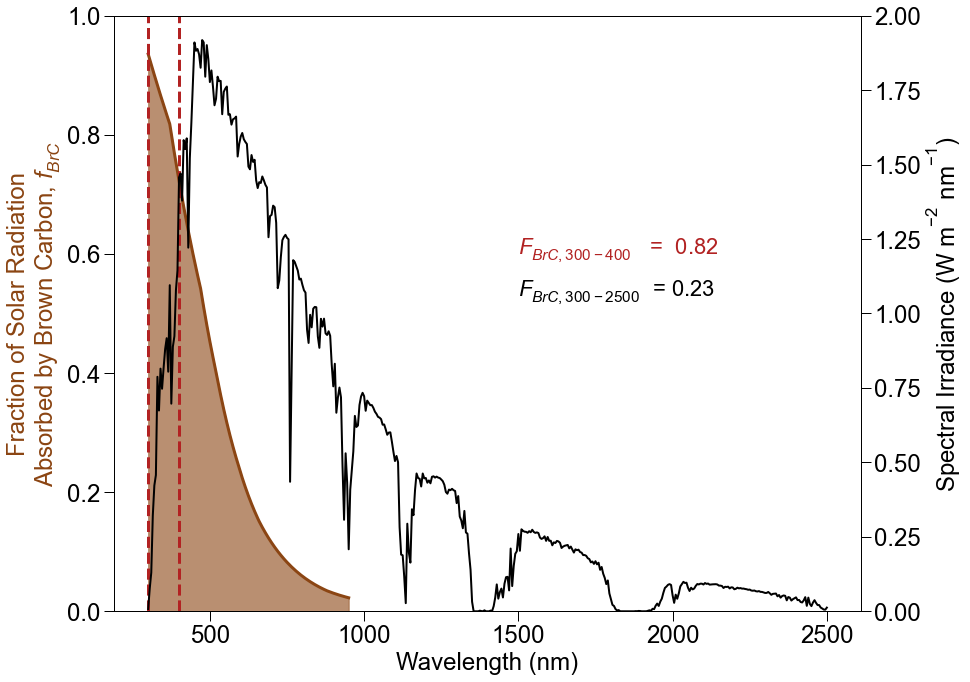

In [43]:
s = 300
e = 950
FOC = np.trapz(ISR.loc[s:e,'foc']*ISR.loc[s:e,'spectral irradiance'],ISR.loc[s:e].index.values) /  np.trapz(ISR['spectral irradiance'],ISR.index)
FOC_UV = np.trapz(ISR.loc[300:400,'foc']*ISR.loc[300:400,'spectral irradiance'],ISR.loc[300:400].index.values) /  np.trapz(ISR.loc[300:400,'spectral irradiance'],ISR.loc[300:400].index.values)

fig,ax=plt.subplots(figsize=(14,10))

ax2 = ax.twinx()

ax2.plot(ISR.index,ISR['spectral irradiance'],'-k',lw=2)
ax.plot(ISR.index,ISR.foc,'-',lw=3,color='#8B4513')
ax.fill_between(ISR.index,ISR.foc,color='#8B4513',alpha=0.6)

ax.annotate('$F_{{BrC,300-2500}}$  = {:.2f}'.format(FOC),xy=(1500,0.53),fontsize=22)
ax.annotate('$F_{{BrC,300-400 }}$   =  {:.2f}'.format(FOC_UV),xy=(1500,0.6),fontsize=22,color='#B22222')

bounds = [300,400]
for i in range(2):
    ax.axvline(x=bounds[i],color='#B22222',lw=3,ls='--',zorder=10)

ax.set_ylim([0,1])
ax2.set_ylim([0,2])

ax.set_ylabel('Fraction of Solar Radiation\nAbsorbed by Brown Carbon, $f_{BrC}$',color = '#8B4513')
ax2.set_ylabel('Spectral Irradiance (W m$^{-2}$ nm$^{-1}$)')
ax.set_xlabel('Wavelength (nm)')

fig.tight_layout()
fig.savefig(plot_dir/'FigS10_FractionBrC_2025-05-04.png')

In [44]:
ISR.loc[370:660].index.values

array([370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430,
       435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495,
       500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560,
       565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625,
       630, 635, 640, 645, 650, 655, 660])

In [45]:
np.trapz(ISR['spectral irradiance'],ISR.index)

1090.441426219485

# Prelimary Absorption vs Wavelength plots

In [46]:
MACS = np.array([18.47,14.54,13.14,11.58,10.35,7.77,7.19])
MACS_norm = MACS / MACS[5]

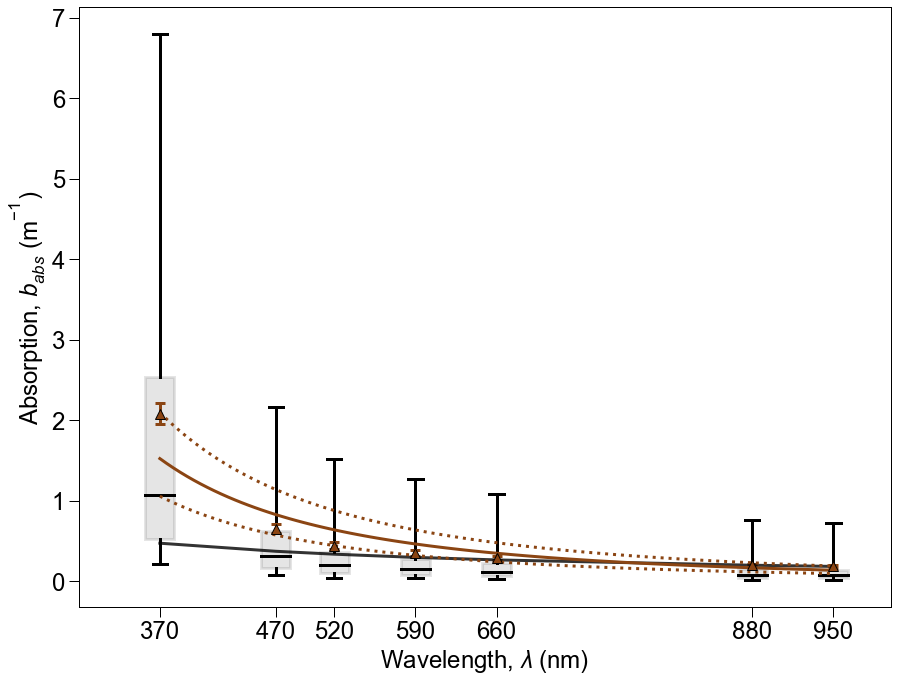

In [48]:
pos = wl
flier_logic = False

# box and whisker
lw = 3
boxprops=dict(linewidth=lw)
medianprops=dict(linewidth=lw,linestyle='-',color='k')
whiskerprops = dict(linewidth=lw)
capprops = dict(linewidth=lw)
meanprops = dict(markersize=15,markerfacecolor='r',markeredgecolor='k')
flierprops = dict(markersize=10)

fig,ax = plt.subplots(figsize=(13,10))

# converstion factor of ug to g
CF = 1e6


box = ax.boxplot(Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']]/CF,
                  positions=pos,whis=[5,95],showfliers=flier_logic,showmeans=False,
                  boxprops=boxprops,flierprops=flierprops,
                  medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,meanprops=meanprops,patch_artist=True,widths=25,zorder=0)

ax.errorbar(x=wl,y=meanAbs/CF,yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()/CF,capsize=5,capthick=3,
            marker='^',color='#8B4513',ms=10,markeredgecolor='k',linestyle='')
ax.plot(wl,meanAbs[5]*MACS_norm/CF,'-k',ms=10,alpha=0.8)

# power law fits
C = np.mean(meanAbs/CF * (wl**AAE7))
Cmin = np.min(meanAbs/CF * (wl**AAE7))
Cmax = np.max(meanAbs/CF * (wl**AAE7))

x = np.linspace(wl[0],wl[6],100)
y = x**(-AAE7)*C
ymin = x**(-AAE7)*Cmin
ymax = x**(-AAE7)*Cmax
ax.plot(x,y,color='#8B4513')
ax.plot(x,ymin,ls=':',color='#8B4513')
ax.plot(x,ymax,ls=':',color='#8B4513')

for i,f in enumerate(wl):
    box['boxes'][i].set(facecolor='k',alpha=0.1)  

ax.set_xlim([300,1000])
ax.set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax.set_ylabel('Absorption, $b_{abs}$ (m$^{-1}$)',fontweight=None)

fig.tight_layout()
manuPath = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/_manuscript/plots/'
#fig.savefig(manuPath + 'Abs_vs_WL_powerlaw_boxplot.png')

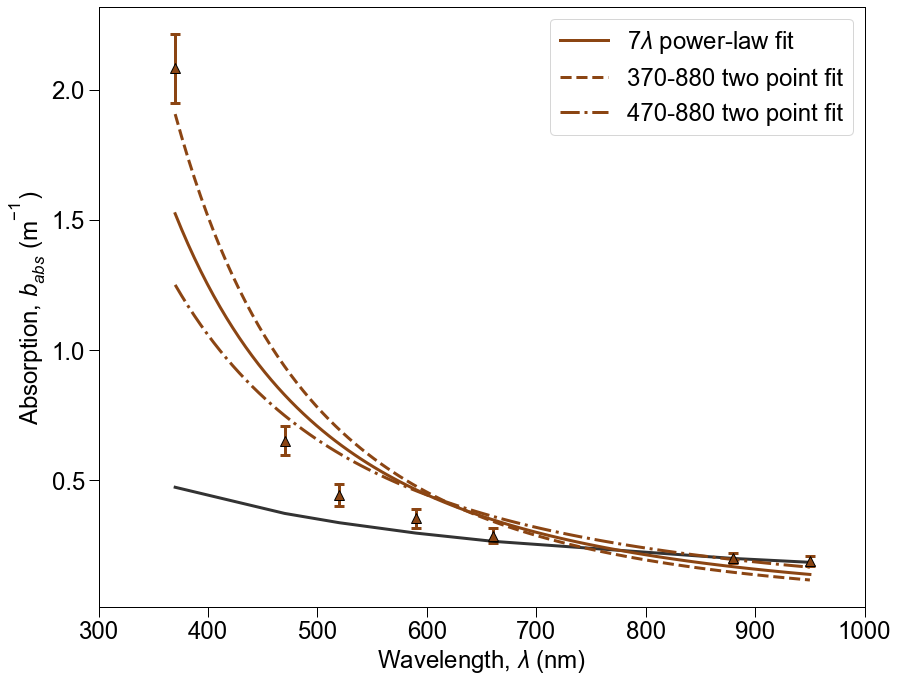

In [49]:
pos = wl
flier_logic = False

# box and whisker
lw = 3
boxprops=dict(linewidth=lw)
medianprops=dict(linewidth=lw,linestyle='-',color='k')
whiskerprops = dict(linewidth=lw)
capprops = dict(linewidth=lw)
meanprops = dict(markersize=15,markerfacecolor='r',markeredgecolor='k')
flierprops = dict(markersize=10)

fig,ax = plt.subplots(figsize=(13,10))

# converstion factor of ug to g
CF = 1e6
ax.errorbar(x=wl,y=meanAbs/CF,yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()/CF,capsize=5,capthick=3,
            marker='^',color='#8B4513',ms=10,markeredgecolor='k',linestyle='')
ax.plot(wl,meanAbs[5]*MACS_norm/CF,'-k',ms=10,alpha=0.8)

# average AAEs
AAE48 = Abs['AAE_470-880'].mean()
AAE38 = Abs['AAE_370-880'].mean()

# power law fits
C = np.mean(meanAbs/CF * (wl**AAE7))
C3 = np.mean(meanAbs/CF * (wl**AAE38))
C4 = np.mean(meanAbs/CF * (wl**AAE48))

x = np.linspace(wl[0],wl[6],100)
y = x**(-AAE7)*C
y3 = x**(-AAE38)*C3
y4 = x**(-AAE48)*C4
ax.plot(x,y,color='#8B4513',label='7$\lambda$ power-law fit')
ax.plot(x,y3,ls='--',color='#8B4513',label='370-880 two point fit')
ax.plot(x,y4,ls='-.',color='#8B4513',label='470-880 two point fit')

for i,f in enumerate(wl):
    box['boxes'][i].set(facecolor='k',alpha=0.1)  

ax.set_xlim([300,1000])
ax.set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax.set_ylabel('Absorption, $b_{abs}$ (m$^{-1}$)',fontweight=None)

ax.legend()
fig.tight_layout()
manuPath = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/_manuscript/plots/'
#fig.savefig(manuPath + 'Abs_vs_WL_2ptComparison.png')

6.659144360961094 0.6648609908011891


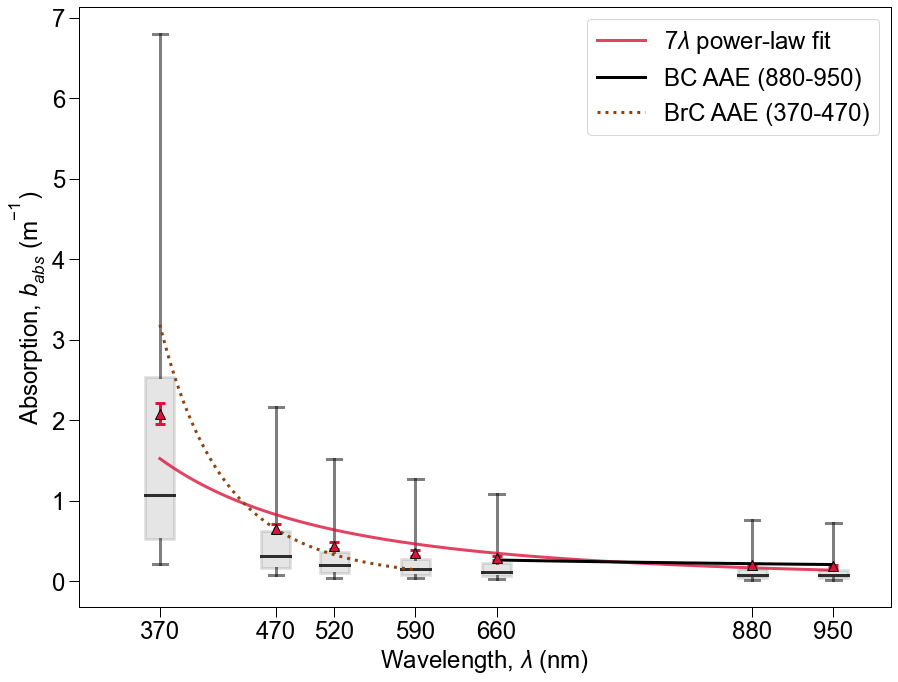

In [50]:
pos = wl
flier_logic = False

# box and whisker
lw = 3
boxprops=dict(linewidth=lw,alpha=0.5)
medianprops=dict(linewidth=lw,linestyle='-',color='k',alpha=0.8)
whiskerprops = dict(linewidth=lw,alpha=0.5)
capprops = dict(linewidth=lw,alpha=0.5)
meanprops = dict(markersize=15,markerfacecolor='r',markeredgecolor='k')
flierprops = dict(markersize=10,alpha=0.5)

fig,ax = plt.subplots(figsize=(13,10))

# converstion factor of ug to g
CF = 1e6
box = ax.boxplot(Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']]/CF,
                 positions=pos,whis=[5,95],showfliers=flier_logic,showmeans=False,
                 boxprops=boxprops,flierprops=flierprops,
                 medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,meanprops=meanprops,patch_artist=True,widths=25,zorder=0)


ax.errorbar(x=wl,y=meanAbs/CF,yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()/CF,capsize=5,capthick=3,
            marker='^',color='#DC143C',ms=10,markeredgecolor='k',linestyle='')
#ax.plot(wl,meanAbs[5]*MACS_norm/CF,'-ok',ms=10,alpha=0.8)

# average AAEs
AAE_BC = Abs['AAE_880-950'].mean()
AAE_BrC = Abs['AAE_370-470'].mean()

# power law fits
C = np.mean(meanAbs/CF * (wl**AAE7))
C_BC = np.mean(meanAbs[4:6]/CF * (wl[4:6]**AAE_BC))
C_BrC = np.mean(meanAbs[0:3]/CF * (wl[0:3]**AAE_BrC))

xBrC = np.linspace(wl[0],wl[3],100)
xBC = np.linspace(wl[4],wl[6],100)
x = np.linspace(wl[0],wl[6],100)

y = x**(-AAE7)*C
yBrC = xBrC**(-AAE_BrC)*C_BrC
yBC = xBC**(-AAE_BC)*C_BC

ax.plot(x,y,color='#DC143C',label='7$\lambda$ power-law fit',alpha=0.8)
ax.plot(xBC,yBC,ls='-',color='k',label='BC AAE (880-950)')
ax.plot(xBrC,yBrC,ls=':',color='#8B4513',label='BrC AAE (370-470)')

for i,f in enumerate(wl):
    box['boxes'][i].set(facecolor='k',alpha=0.1)  

ax.set_xlim([300,1000])
ax.set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax.set_ylabel('Absorption, $b_{abs}$ (m$^{-1}$)',fontweight=None)

ax.legend()
fig.tight_layout()
manuPath = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/_manuscript/plots/'
print(AAE_BrC,AAE_BC)
#fig.savefig(manuPath + 'Abs_vs_WL_BC-BrC_bifurcate.png')

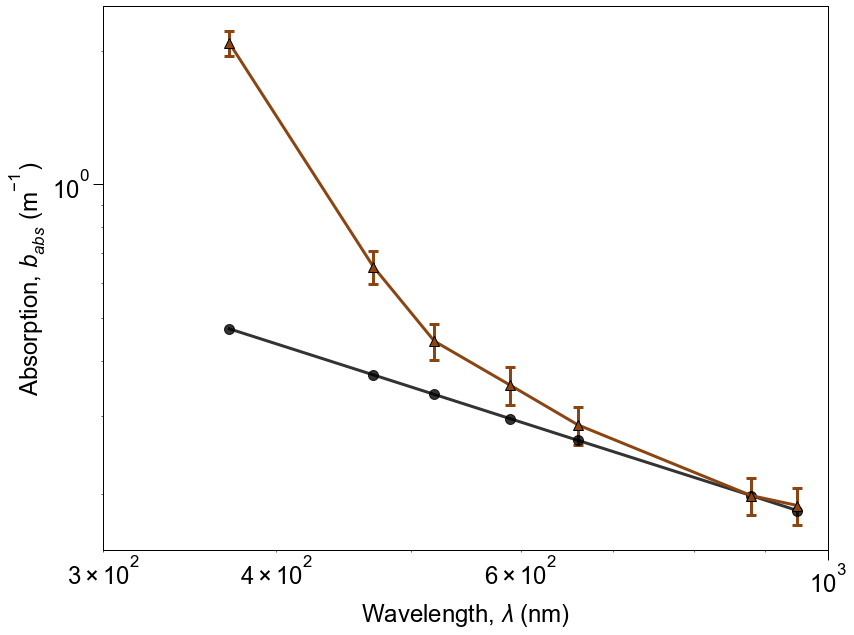

In [51]:
pos = wl
flier_logic = False

# box and whisker
lw = 3
boxprops=dict(linewidth=lw)
medianprops=dict(linewidth=lw,linestyle='-',color='k')
whiskerprops = dict(linewidth=lw)
capprops = dict(linewidth=lw)
meanprops = dict(markersize=15,markerfacecolor='r',markeredgecolor='k')
flierprops = dict(markersize=10)

fig,ax = plt.subplots(figsize=(13,10))

# box = ax.boxplot(AAEmin[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']],
#                  positions=pos,whis=[5,95],showfliers=flier_logic,showmeans=False,
#                  boxprops=boxprops,flierprops=flierprops,
#                  medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops,meanprops=meanprops,patch_artist=True,widths=25,zorder=0)

# converstion factor of ug to g
CF = 1e6
ax.errorbar(x=wl,y=meanAbs/CF,yerr=Abs[['b_370', 'b_470', 'b_520', 'b_590', 'b_660', 'b_880', 'b_950']].sem()/CF,capsize=5,capthick=3,
            marker='^',color='#8B4513',ms=10,markeredgecolor='k')
ax.plot(wl,meanAbs[5]*MACS_norm/CF,'-ok',ms=10,alpha=0.8)

for i,f in enumerate(wl):
    box['boxes'][i].set(facecolor='k',alpha=0.1)  

ax.set_xlim([300,1000])
ax.set_xlabel('Wavelength, $\lambda$ (nm)',fontweight=None)
ax.set_ylabel('Absorption, $b_{abs}$ (m$^{-1}$)',fontweight=None)

ax.set_yscale('log')
ax.set_xscale('log')

#fig.tight_layout()